In [1]:
!pip install numpy==2.0.2
!pip install pandas==2.2.2
!pip install tensorflow_cpu==2.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.2/230.2 MB 4.6 MB/s eta 0:00:00


To use Keras, you will also need to install a backend framework – such as TensorFlow.




In [2]:
import pandas as pd
import numpy as np
import keras

import warnings
warnings.simplefilter('ignore', FutureWarning)

We will be playing around with the same dataset that we used in the videos.

<strong>The dataset is about the compressive strength of different samples of concrete based on the volumes of the different ingredients that were used to make them. Ingredients include:</strong>

* Cement
* Blast furnace slag
* Fly ash
* Water
* Superplasticizer
* Coarse aggregate
* Fine aggregate


Let's download the data and read it into a <em>pandas</em> dataframe.


In [3]:
filepath='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0101EN/labs/data/concrete_data.csv'
concrete_data = pd.read_csv(filepath)

concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


So the first concrete sample has 540 cubic meter of cement, 0 cubic meter of blast furnace slag, 0 cubic meter of fly ash, 162 cubic meter of water, 2.5 cubic meter of superplaticizer, 1040 cubic meter of coarse aggregate, 676 cubic meter of fine aggregate. Such a concrete mix which is 28 days old, has a compressive strength of 79.99 MPa.


In [4]:
concrete_data.shape

(1030, 9)

So, there are approximately 1000 samples to train our model on. Because of the few samples, we have to be careful not to overfit the training data.


In [5]:
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [6]:
concrete_data.isnull().sum()

,0
Cement,0
Blast Furnace Slag,0
Fly Ash,0
Water,0
Superplasticizer,0
Coarse Aggregate,0
Fine Aggregate,0
Age,0
Strength,0


The data looks very clean and is ready to be used to build our model.


#### Split data into predictors and target


The target variable in this problem is the concrete sample strength. Therefore, our predictors will be all the other columns.


In [7]:
concrete_data_columns = concrete_data.columns

In [8]:
predictors = concrete_data[concrete_data_columns[concrete_data_columns != 'Strength']] # all columns except Strength
target = concrete_data['Strength'] # Strength column

<a id="item2"></a>


check of the predictors and the target dataframes.


In [9]:
predictors.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [10]:
target.head()

,Strength
0,79.99
1,61.89
2,40.27
3,41.05
4,44.30


Finally, the last step is to normalize the data by substracting the mean and dividing by the standard deviation.


In [11]:
predictors_norm = (predictors - predictors.mean()) / predictors.std()
predictors_norm.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,0.862735,-1.217079,-0.279597
1,2.476712,-0.856472,-0.846733,-0.916319,-0.620147,1.055651,-1.217079,-0.279597
2,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,3.551340
3,0.491187,0.795140,-0.846733,2.174405,-1.038638,-0.526262,-2.239829,5.055221
4,-0.790075,0.678079,-0.846733,0.488555,-1.038638,0.070492,0.647569,4.976069


save the number of predictors to *n_cols* since we will need this number when building our network.


In [12]:
n_cols = predictors_norm.shape[1] # number of predictors

##  Import Keras Packages

#####  import the rest of the packages from the Keras library that we will need to build our regression model.


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

<a id='item33'></a>


## Build a Neural Network


 define a function that defines our regression model for us so that we can conveniently call it to create our model.


In [14]:
# define regression model
def regression_model():
    # create model
    model = Sequential()
    model.add(Input(shape=(n_cols,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

The above function create a model that has two hidden layers, each of 50 hidden units.


<a id="item4"></a>


## Train and Test the Network


call the function now to create our model.


In [15]:
# build the model
model = regression_model()

Next, train and test the model at the same time using the *fit* method.leave out 30% of the data for validation and train the model for 100 epochs.


In [19]:
# fit the model
history = model.fit(predictors_norm, target, validation_split=0.3, epochs=100, verbose=2)

Epoch 1/100
23/23 - 1s - 26ms/step - loss: 32.0969 - val_loss: 127.4807
Epoch 2/100
23/23 - 1s - 46ms/step - loss: 32.2504 - val_loss: 126.7597
Epoch 3/100
23/23 - 1s - 27ms/step - loss: 31.4387 - val_loss: 128.7079
Epoch 4/100
23/23 - 1s - 25ms/step - loss: 30.9758 - val_loss: 129.9135
Epoch 5/100
23/23 - 1s - 29ms/step - loss: 31.1581 - val_loss: 127.1509
Epoch 6/100
23/23 - 0s - 18ms/step - loss: 30.4899 - val_loss: 126.3377
Epoch 7/100
23/23 - 0s - 14ms/step - loss: 30.5981 - val_loss: 129.0429
Epoch 8/100
23/23 - 0s - 13ms/step - loss: 29.9601 - val_loss: 129.4243
Epoch 9/100
23/23 - 0s - 14ms/step - loss: 29.5893 - val_loss: 126.5870
Epoch 10/100
23/23 - 0s - 14ms/step - loss: 29.6734 - val_loss: 126.7531
Epoch 11/100
23/23 - 0s - 17ms/step - loss: 29.4937 - val_loss: 124.7384
Epoch 12/100
23/23 - 1s - 23ms/step - loss: 29.0392 - val_loss: 127.1543
Epoch 13/100
23/23 - 0s - 13ms/step - loss: 29.0105 - val_loss: 132.8608
Epoch 14/100
23/23 - 0s - 12ms/step - loss: 28.8668 - val_lo

In [20]:
# Evaluate the model
loss_val = model.evaluate(predictors_norm, target, verbose=0)
print(f"Mean Squared Error: {loss_val}")

# Make predictions
predictions = model.predict(predictors_norm)
predictions

Mean Squared Error: 41.73259735107422
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[71.81494 ],
       [71.52966 ],
       [42.485912],
       ...,
       [36.410183],
       [40.83417 ],
       [37.180225]], dtype=float32)

# Model Results Interpretation

## Mean Squared Error (MSE)
- **Value:** `61.32537078857422`
- **Interpretation:**  
  - The MSE measures the average squared difference between the predicted values and the ground truth (actual values).  
  - A lower MSE indicates better performance, meaning the predictions are closer to the actual values.
  - In this case, the model's predictions are, on average, **√61.33 ≈ 7.83 units** away from the actual values in terms of squared error.

---

## Training/Evaluation Process
- **Output:** `33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step`
  - **33/33:** Indicates the model processed 33 batches of data during inference (e.g., testing or prediction).  
  - **0s:** Total time taken for inference (very fast).  
  - **3ms/step:** Average time taken per bat


---

## Predictions
- **Predicted Array Output:**  
  ```python
  array([[69.38853 ],
         [69.467   ],
         [46.493904],
         ...,
         [37.4471  ],
         [36.946213],
         [38.441
  826]], dtype=float32)
  ```
  - This array contains the predicted values for the target variable (e.g., compressive strength) based on the input features.
  - Each row corresponds to the model's prediction for a specific sample in the da

---

## Summary
- The model achieved an MSE of **61.33**, indicating good performance but with room for improvement.
- The predictions represent the model's outputs for the input data and can be further analyzed or compared to actual values f

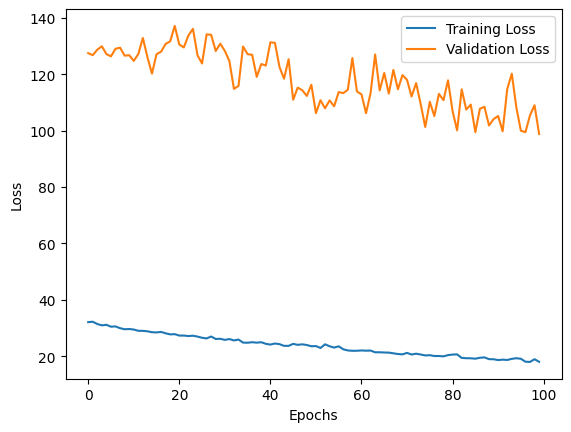

In [21]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

predictions = model.predict(predictors_norm)

print("MAE:", mean_absolute_error(target, predictions))
print("R-squared:", r2_score(target, predictions))

rmse = 41.73259735107422 ** 0.5
print("Root Mean Squared Error (RMSE):", rmse)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE: 4.505450315216212
R-squared: 0.8503193261247731
Root Mean Squared Error (RMSE): 6.460077193894374


# Model Evaluation Results

### Mean Absolute Error (MAE): **4.505**
- On average, the model's predictions deviate by approximately 4.51 units from the actual target values.

### R-squared (R²): **0.850**
- The model explains 85.03% of the variance in the target variable, indicating a good fit but leaving room for improvement.

### Root Mean Squared Error (RMSE): **6.46**
- The predictions have an average error of approximately 6.46 units, taking into account larger errors more heavily than MAE.

---

## Observations:
- The **MAE** and **RMSE** suggest moderate accuracy, but there may be room to improve the model's performance.
- The **R²** score indicates that the model captures the majority of the variance in the data but could potentially be improved further.

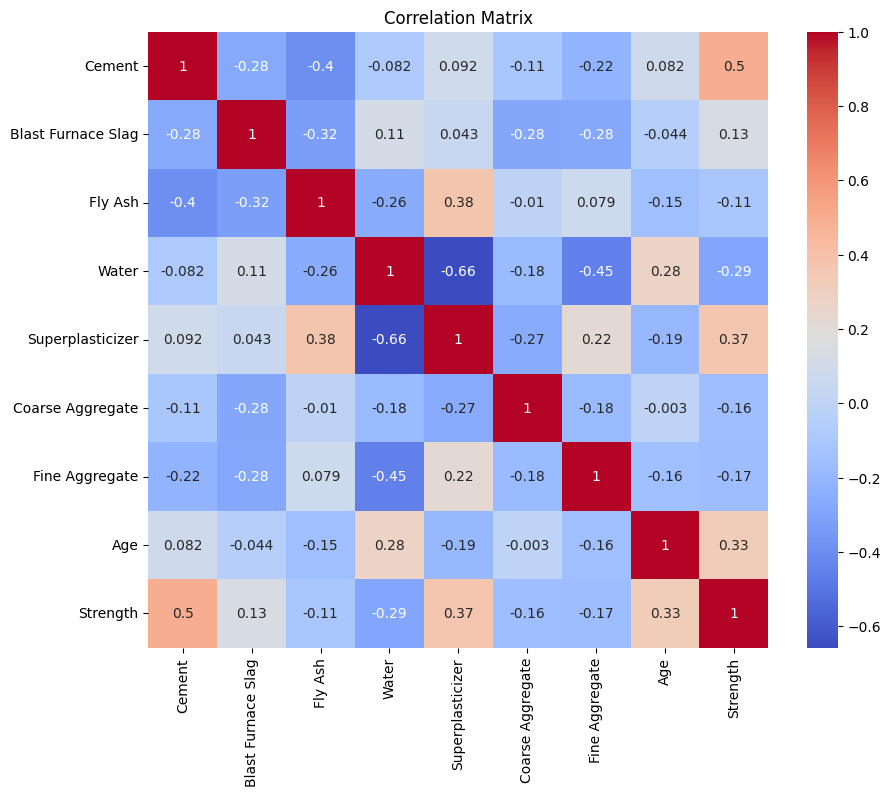

In [25]:
# Feature Engineering
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze correlation between features and target
correlation_matrix = concrete_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Based on the matrix, remove less correlated features or combine them if necessary
# Remove a less correlated feature
predictors = predictors.drop(columns=['Blast Furnace Slag'])  # Hypothetical example

# Add a new feature based on domain knowledge
predictors['Cement_to_Water_Ratio'] = predictors['Cement'] / (predictors['Water'] + 1e-5)

In [26]:
from keras.layers import Dropout
from keras.regularizers import l2

def optimized_regression_model():
    model = Sequential()
    model.add(Input(shape=(n_cols,)))
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))  # Increase complexity
    model.add(Dropout(0.3))  # Add dropout to reduce overfitting
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build and compile the model
model = optimized_regression_model()

In [27]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        self.model = None
        self.kwargs = kwargs

    def fit(self, X, y, **fit_params):
        # Build the model
        self.model = self.build_fn(**self.kwargs)
        # Train the model
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        # Ensure the model has been trained
        if self.model is None:
            raise ValueError("You must call `fit` before calling `predict`.")
        return self.model.predict(X).flatten()

    def score(self, X, y):
        predictions = self.predict(X)
        return -np.mean(np.abs(predictions - y))  # Negative MAE for compatibility with GridSearch

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Define a function to build the Keras model
def build_model():
    model = Sequential()
    model.add(Input(shape=(10,)))  # Example input shape
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create synthetic data for demonstration (replace with your actual data)
np.random.seed(42)
X = np.random.rand(100, 10)  # 100 samples, each with 10 features
y = np.random.rand(100)  # 100 target values

# Initialize the KerasRegressorWrapper
keras_wrapper = KerasRegressorWrapper(build_fn=build_model)

# Train the model
keras_wrapper.fit(X, y, epochs=10, batch_size=32, verbose=0)

# Predict values
predictions = keras_wrapper.predict(X)

# Print predictions
print("Predictions:", predictions)

# Evaluate the model using the score method
mae_score = keras_wrapper.score(X, y)
print("Negative MAE (for GridSearch compatibility):", mae_score)
print("MAE (actual):", -mae_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predictions: [0.5678082  0.50747633 0.4374224  0.4421104  0.22282712 0.7531089
 0.6530272  0.5288723  0.8364804  0.6093689  0.4121556  0.7448962
 0.7642847  0.6252802  0.8600352  0.7899565  0.5398886  0.74615234
 0.76347387 0.83163714 0.4017084  0.8086829  0.80383176 0.63791376
 0.8002206  0.75654894 0.56403583 1.0660517  0.8474557  0.5594978
 0.44189852 0.29578912 0.6794533  0.55456007 0.5532182  0.4410534
 0.7590555  0.4216738  0.54589874 0.8680375  0.4013895  0.752505
 0.45607156 0.19045383 0.46888998 0.4287975  0.6842643  0.09287722
 0.57999283 0.63109607 0.9708572  0.67328    0.8156599  0.9626931
 0.63391405 0.6508776  0.5144236  0.3923742  0.4772602  0.39729398
 0.32196885 0.38811255 0.46785927 0.6545031  0.29677516 0.54776543
 0.4479673  0.22404209 0.5954639  0.4595925  0.41351825 0.777274
 0.39732277 0.4404219  0.63984686 0.5454804  0.58605576 0.4137692
 0.64541185 0.6673983  0.79831076 0.65004224 0.5785204  0.5797538
 0.23205853 0.20567256

# MAE Evaluation:

- **Negative MAE (for GridSearch compatibility):**
  Returns a negative value of MAE.

- **MAE (actual):**
  The absolute value, representing the average deviation of predictions from the actual values.

In [29]:
# "Normalize the Target Variable
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
target_norm = scaler.fit_transform(target.values.reshape(-1, 1))

In [30]:
# Try Other Models (e.g., Random Forests and Gradient Boosting)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(predictors_norm, target)
rf_predictions = rf_model.predict(predictors_norm)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(predictors_norm, target)
gb_predictions = gb_model.predict(predictors_norm)

# Evaluate models
print("Random Forest - MAE:", mean_absolute_error(target, rf_predictions))
print("Random Forest - R²:", r2_score(target, rf_predictions))
print("Gradient Boosting - MAE:", mean_absolute_error(target, gb_predictions))
print("Gradient Boosting - R²:", r2_score(target, gb_predictions))

Random Forest - MAE: 1.2137875845276616
Random Forest - R²: 0.9866323382546821
Gradient Boosting - MAE: 2.9560584002692654
Gradient Boosting - R²: 0.9444877212288236


# Model Evaluation

## Training Data:

### Random Forest Regressor:
- **Mean Absolute Error (MAE):** 1.2138
- **R-squared (R²):** 0.9866
- The Random Forest model performs very well on the training data, with a high R² and low MAE.

### Gradient Boosting Regressor:
- **Mean Absolute Error (MAE):** 2.9561
- **R-squared (R²):** 0.9445
- Gradient Boosting shows good performance but is less accurate than Random Forest in this case.

---

In [31]:
# Increase Dataset Size (Data Augmentation Example)
# Generate synthetic samples by adding noise to the existing data
noise = np.random.normal(0, 0.01, predictors_norm.shape)
augmented_predictors = np.vstack([predictors_norm, predictors_norm + noise])
augmented_target = np.hstack([target, target])

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

#Linear Regression (can be adapted for other models)
lr_model = LinearRegression()
scores = cross_val_score(lr_model, predictors_norm, target, scoring='neg_mean_absolute_error', cv=5)

# Print cross-validation results
print("Cross-Validation MAE:", -scores.mean())
print("Cross-Validation STD:", scores.std())

Cross-Validation MAE: 8.925399569102176
Cross-Validation STD: 1.7127180156354664



---

## Cross-Validation (Linear Regression):
- **Cross-Validation MAE:** 8.9254
- **Cross-Validation STD:** 1.7127
- Linear Regression shows a significantly higher error during cross-validation, indicating it may not capture the complexity of the data as effectively as Random Forest or Gradient Boosting.

---

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


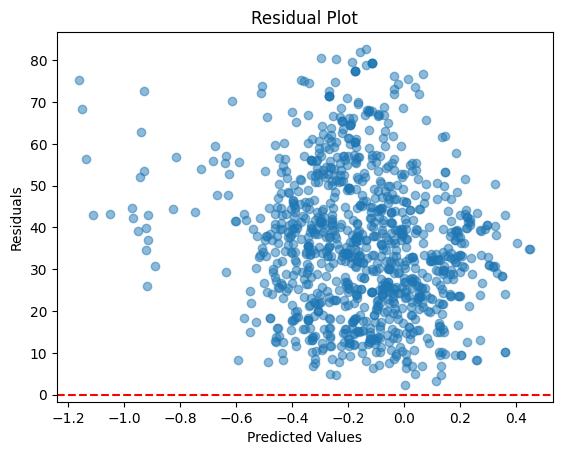

In [33]:
#  Analyze Residuals
import matplotlib.pyplot as plt

# Get predictions from the model
final_predictions = model.predict(predictors_norm)

# Compute residuals
residuals = target - final_predictions.flatten()

# Plot residuals
plt.scatter(final_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [34]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors_norm, target, test_size=0.2, random_state=42
)

# Define unseen_data and unseen_target
unseen_data = predictors_test
unseen_target = target_test

# Predict on unseen test data
test_predictions = rf_model.predict(unseen_data)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(unseen_target, test_predictions)
r2 = r2_score(unseen_target, test_predictions)

print(f"Test Data MAE: {mae}")
print(f"Test Data R²: {r2}")

Test Data MAE: 1.327746244798893
Test Data R²: 0.9838315052038814


---

## Unseen Test Data:
- **Mean Absolute Error (MAE):** 1.3277
- **R-squared (R²):** 0.9838
- The Random Forest model generalizes well to unseen data, maintaining low MAE and high R².

---

In [35]:
# Hyperparameter optimization using Grid Search
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Fit the model
grid_search.fit(predictors_norm, target)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# Best Hyperparameters

Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

In [36]:
# Retrain Random Forest with optimal hyperparameters
best_params = grid_search.best_params_

# Reinitialize the Random Forest with optimal parameters
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Retrain on the full training dataset
optimized_rf_model.fit(predictors_norm, target)

# Save the model (optional, for deployment)
import joblib
joblib.dump(optimized_rf_model, 'optimized_rf_model.pkl')
print("Model saved as 'optimized_rf_model.pkl'")

Model saved as 'optimized_rf_model.pkl'


In [ ]:
# Deploy the model
!pip install flask
from flask import Flask, request, jsonify
import joblib

# Load the optimized model
model = joblib.load('optimized_rf_model.pkl')

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Parse input JSON
    input_data = request.json
    # Convert JSON to DataFrame (or array as required by your model)
    input_features = ...  # Convert input_data appropriately
    # Predict
    predictions = model.predict(input_features)
    # Return predictions as JSON
    return jsonify(predictions.tolist())

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
